In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler,PolynomialFeatures
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
aisles = pd.read_csv("./Data/aisles.csv")
departments = pd.read_csv("./Data/departments.csv")
order_products__prior = pd.read_csv("./Data/order_products__prior.csv")
order_products__train = pd.read_csv("./Data/order_products__train.csv")
orders = pd.read_csv("./Data/orders.csv")
products = pd.read_csv("./Data/Products.csv")

In [3]:
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
orders_train = orders[orders['eval_set'] == 'train']

In [46]:
X = order_products__train.merge(orders_train, on="order_id", how="left")

In [47]:
X.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0


In [48]:
X.drop(labels=['eval_set', 'reordered', 'order_id', 'add_to_cart_order'], axis=1, inplace=True)

## Замена времени суток на промежутки
0: 0 - 3

1: 4 - 7

2: 8 - 11

3: 12 - 15

4: 16 - 19

5: 20 - 23

In [49]:
# Разбиваем на интервалы и присваиваем метки
bins = [-1, 3, 7, 11, 15, 19, 23]  # Границы интервалов
labels = [0, 1, 2, 3, 4, 5]        # Метки для интервалов
X['time_period'] = pd.cut(X['order_hour_of_day'], bins=bins, labels=labels)


In [122]:
X.head(10)

,product_id,user_id,order_number,order_dow,days_since_prior_order
0,49302,112108,4,4,9.0
1,11109,112108,4,4,9.0
2,10246,112108,4,4,9.0
3,49683,112108,4,4,9.0
4,43633,112108,4,4,9.0
5,13176,112108,4,4,9.0
6,47209,112108,4,4,9.0
7,22035,112108,4,4,9.0
8,39612,79431,23,6,30.0
9,19660,79431,23,6,30.0


In [51]:
y = X['time_period']

In [52]:
X.drop(labels=['order_hour_of_day', 'time_period'], axis=1, inplace=True)

In [53]:
X.head()

,product_id,user_id,order_number,order_dow,days_since_prior_order
0,49302,112108,4,4,9.0
1,11109,112108,4,4,9.0
2,10246,112108,4,4,9.0
3,49683,112108,4,4,9.0
4,43633,112108,4,4,9.0


In [54]:
X.shape, y.shape

((1384617, 5), (1384617,))

In [55]:
X.isnull().sum()

product_id                0
user_id                   0
order_number              0
order_dow                 0
days_since_prior_order    0
dtype: int64

In [56]:
# Шкалируем данные X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Решение задачи регрессии

In [108]:
mean_scores = {}

## XGBRegressor

In [91]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

In [93]:
%%time
xgb_scores = cross_validate(xgb_model, X_scaled, y, scoring='neg_mean_squared_error')

Wall time: 18.4 s


In [94]:
xgb_scores

{'fit_time': array([3.58711004, 3.51421452, 3.44670892, 3.45227623, 3.42593503]),
 'score_time': array([0.18748927, 0.17187119, 0.24902558, 0.17186046, 0.185256  ]),
 'test_score': array([-1.16402438, -1.18101942, -1.18184673, -1.19879159, -1.19855253])}

In [112]:
mean_scores["XGBRegressor"] = -xgb_scores['test_score'].mean()

## LinearRegression

In [97]:
lr_model  = LinearRegression()

In [99]:
%%time
lr_scores = cross_validate(lr_model , X_scaled, y, scoring='neg_mean_squared_error')

Wall time: 1.12 s


In [100]:
lr_scores

{'fit_time': array([0.2301147 , 0.18749952, 0.19876242, 0.20704675, 0.19822359]),
 'score_time': array([0.        , 0.01561999, 0.        , 0.01065302, 0.        ]),
 'test_score': array([-1.14741299, -1.15565483, -1.15168726, -1.17755307, -1.17238416])}

In [113]:
mean_scores["LinearRegression"] = -lr_scores['test_score'].mean()

## LGBMRegressor

In [101]:
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42)


In [102]:
%%time
lgb_scores = cross_validate(lgb_model, X_scaled, y, scoring='neg_mean_squared_error')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 1107693, number of used features: 5
[LightGBM] [Info] Start training from score 3.021117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 1107693, number of used features: 5
[LightGBM] [Info] Start training from score 3.013762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [103]:
lgb_scores

{'fit_time': array([1.3760221 , 1.43009162, 1.54447222, 1.34301305, 1.31812286]),
 'score_time': array([0.1394155 , 0.19038153, 0.13417602, 0.14930081, 0.14060545]),
 'test_score': array([-1.14551594, -1.15335348, -1.14985972, -1.17661564, -1.172456  ])}

In [114]:
mean_scores["LGBMRegressor"] = -lgb_scores['test_score'].mean()

## MLPRegressor

In [104]:
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=200, random_state=42)

In [105]:
%%time
mlp_scores = cross_validate(mlp_model , X_scaled, y, scoring='neg_mean_squared_error')

Wall time: 5min 15s


In [107]:
mlp_scores

{'fit_time': array([64.03585982, 58.37432551, 50.02722239, 67.59663939, 74.46277094]),
 'score_time': array([0.22372055, 0.21214437, 0.21626616, 0.20290422, 0.21928096]),
 'test_score': array([-1.14939551, -1.15914586, -1.1549034 , -1.17965755, -1.17762169])}

In [115]:
mean_scores["MLPRegressor"] = -mlp_scores['test_score'].mean()

## Визуализация

In [120]:
mean_scores

{'XGBRegressor': 1.1848469302777163,
 'LinearRegression': 1.160938461487461,
 'LGBMRegressor': 1.1595601545771388,
 'MLPRegressor': 1.1641448021691712}

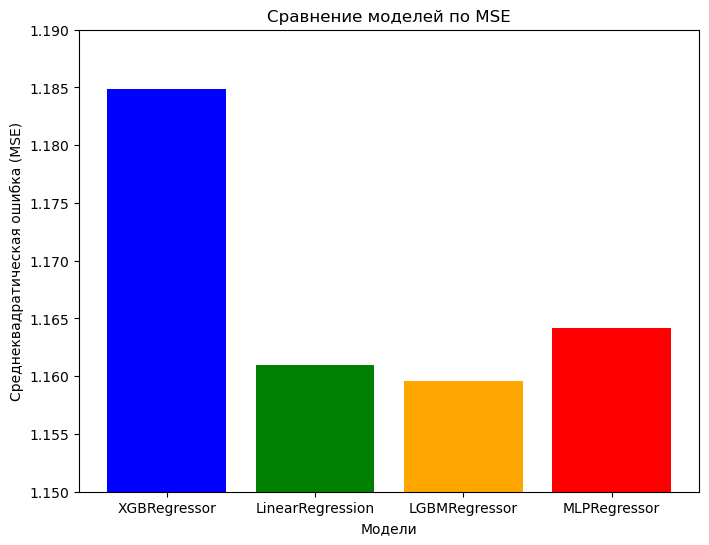

In [121]:
# Создание гистограммы
plt.figure(figsize=(8, 6))
plt.bar(mean_scores.keys(), mean_scores.values(), color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Модели')
plt.ylabel('Среднеквадратическая ошибка (MSE)')
plt.title('Сравнение моделей по MSE')
plt.ylim(1.15, 1.19)  # Задание диапазона для оси Y
plt.show()

## Тестовое предсказание

In [124]:
products[products['product_id'] == 49302]

,product_id,product_name,aisle_id,department_id
49301,49302,Bulgarian Yogurt,120,16


In [125]:
X[X['user_id'] == 112108]

,product_id,user_id,order_number,order_dow,days_since_prior_order
0,49302,112108,4,4,9.0
1,11109,112108,4,4,9.0
2,10246,112108,4,4,9.0
3,49683,112108,4,4,9.0
4,43633,112108,4,4,9.0
5,13176,112108,4,4,9.0
6,47209,112108,4,4,9.0
7,22035,112108,4,4,9.0


In [131]:
data_test = pd.DataFrame(data=[[49302, 112108, 5, 5, 12]], columns=X.columns)
data_test

,product_id,user_id,order_number,order_dow,days_since_prior_order
0,49302,112108,5,5,12


In [132]:
scaler = StandardScaler()
data_test_scaled = scaler.fit_transform(data_test)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=7)

In [140]:
lr_model = LinearRegression()

In [141]:
lr_model.fit(X_train, y_train)

LinearRegression()

In [143]:
print("Примерное время заказа данного продукта в определённый день:", lr_model.predict(data_test_scaled)[0])

Примерное время заказа данного продукта в определённый день: 3.019482170999755
